In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
print("scikit-learn installed successfully!")

scikit-learn installed successfully!


In [9]:
df = pd.read_pickle('../data/clean_data.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1393 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   battery_power  1393 non-null   int16   
 1   blue           1393 non-null   category
 2   clock_speed    1393 non-null   float16 
 3   dual_sim       1393 non-null   category
 4   fc             1393 non-null   int8    
 5   four_g         1393 non-null   category
 6   int_memory     1393 non-null   int8    
 7   m_dep          1393 non-null   float16 
 8   mobile_wt      1393 non-null   int16   
 9   n_cores        1393 non-null   int8    
 10  pc             1393 non-null   int8    
 11  px_height      1393 non-null   int16   
 12  px_width       1393 non-null   int16   
 13  ram            1393 non-null   int16   
 14  sc_h           1393 non-null   int8    
 15  sc_w           1393 non-null   int8    
 16  talk_time      1393 non-null   int8    
 17  three_g        1393 non-null   categor

In [10]:
df = df.rename(columns={'price_range': 'target'})
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=2)

In [11]:
cat_features = df.drop('target', axis=1) \
                    .select_dtypes(include=['category']).columns.to_list()
print(cat_features)

['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']


In [12]:
num_features = df.select_dtypes(include=['number']).columns.to_list()
print(num_features)

['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']


In [13]:
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.ensemble import RandomForestClassifier
s_scaler = StandardScaler()
l_encoder = TargetEncoder()
classifier = RandomForestClassifier()

In [14]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' )

In [15]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', classifier)])

pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

predictions = pipeline.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

print(metrics)

{'precision': 0.8410137091353888, 'recall': 0.8424068767908309, 'f1': 0.8412846697870738}


In [17]:
import mlflow

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)   

In [18]:
EXPERIMENT_NAME = "phone_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "phone_model_rf"

In [19]:
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)

c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [20]:
req_file = '../requirements.txt'
params_dict = pipeline.get_params()

In [21]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id
    
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
  
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)

    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2025/10/18 11:20:02 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/18 11:20:02 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/18 11:20:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline model at: http://127.0.0.1:5000/#/experiments/1/runs/35113b2daaf8491b8bdfecc52c5f6a56.
2025/10/18 11:20:02 INFO mlflow.tracking._

In [22]:
classifier2 = RandomForestClassifier()

In [23]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', classifier2)])

print(pipeline.fit(X_train, y_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi'])])),
                ('model', RandomForestClassifier())])


In [24]:
predictions = pipeline.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

print(metrics)

{'precision': 0.8122252996803198, 'recall': 0.8137535816618912, 'f1': 0.8129027091606199}


In [25]:
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer, QuantileTransformer

X_train_fe_sklearn = X_train.copy()

pf = PolynomialFeatures(degree=2)

X_train_fe_sklearn

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
1274,1602,0,2.699219,0,4,1,46,0.600098,118,1,5,273,1062,1862,16,9,2,1,0,1
991,860,1,1.599609,1,13,0,48,0.500000,187,7,18,335,1463,1870,17,2,18,1,0,0
1720,1248,0,2.400391,0,6,1,9,0.399902,89,3,8,71,1686,2454,9,8,13,1,1,0
169,1569,0,2.800781,1,17,0,44,0.300049,110,4,20,45,1942,1260,9,2,17,1,0,0
151,742,0,2.199219,1,4,0,56,0.199951,190,7,14,577,1359,3557,16,11,12,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,1260,0,0.600098,0,5,1,13,1.000000,106,6,6,165,736,2710,13,1,8,1,1,0
443,1448,0,1.400391,1,13,0,26,1.000000,156,3,16,1792,1850,1175,12,9,6,0,1,0
716,863,0,1.599609,1,5,1,6,0.700195,133,4,13,717,1799,520,10,2,18,1,0,1
767,1853,0,0.500000,1,1,0,27,0.300049,197,6,13,985,1005,1973,10,2,8,1,0,1


In [26]:
pf.fit_transform(X_train_fe_sklearn[['battery_power','clock_speed']])

array([[1.0000000e+00, 1.6020000e+03, 2.6992188e+00, 2.5664040e+06,
        4.3241484e+03, 7.2857819e+00],
       [1.0000000e+00, 8.6000000e+02, 1.5996094e+00, 7.3960000e+05,
        1.3756641e+03, 2.5587502e+00],
       [1.0000000e+00, 1.2480000e+03, 2.4003906e+00, 1.5575040e+06,
        2.9956875e+03, 5.7618752e+00],
       ...,
       [1.0000000e+00, 8.6300000e+02, 1.5996094e+00, 7.4476900e+05,
        1.3804629e+03, 2.5587502e+00],
       [1.0000000e+00, 1.8530000e+03, 5.0000000e-01, 3.4336090e+06,
        9.2650000e+02, 2.5000000e-01],
       [1.0000000e+00, 1.8310000e+03, 2.3007812e+00, 3.3525610e+06,
        4.2127305e+03, 5.2935944e+00]], dtype=float32)

In [27]:
sp = SplineTransformer(n_knots=3, degree=3)
sp.fit_transform(X_train_fe_sklearn[['battery_power']])

array([[0.00000000e+00, 2.46807807e-02, 4.97104628e-01, 4.60806518e-01,
        1.74080730e-02],
       [2.34852789e-02, 4.91792463e-01, 4.66333319e-01, 1.83889394e-02,
        0.00000000e+00],
       [1.34136544e-09, 1.67670675e-01, 6.66662655e-01, 1.65666669e-01,
        0.00000000e+00],
       ...,
       [2.29467841e-02, 4.89326304e-01, 4.68873106e-01, 1.88538066e-02,
        0.00000000e+00],
       [0.00000000e+00, 1.21165043e-03, 2.78655972e-01, 6.32773879e-01,
        8.73584981e-02],
       [0.00000000e+00, 1.85106960e-03, 2.97559585e-01, 6.22440513e-01,
        7.81488322e-02]])

In [28]:
qt = QuantileTransformer()
qt.fit_transform(X_train_fe_sklearn[['battery_power']])

array([[0.72272272],
       [0.25675676],
       [0.48825821],
       ...,
       [0.25982742],
       [0.88988989],
       [0.87337337]])

In [29]:
pf = PolynomialFeatures(degree=2)
qt = QuantileTransformer()
sp = SplineTransformer(n_knots=3, degree=3)

In [30]:
pf_pipeline = Pipeline(steps=[
    ('poly', pf),
    ('scale', StandardScaler())
])

In [31]:
preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('quantile', qt, num_features),
        ('poly', pf_pipeline, ['battery_power', 'clock_speed']),
        ('spline', sp, ['battery_power'])
    ],
    remainder='drop',
    )

In [32]:
X_train_fe_sklearn[['battery_power','clock_speed']] = X_train_fe_sklearn[['battery_power','clock_speed']].astype('float64')
X_train_fe_sklearn[['battery_power','clock_speed']] = X_train_fe_sklearn[['battery_power','clock_speed']].astype('float64')

In [33]:
X_train_sklearn_raw = preprocessor_sklearn.fit_transform(X_train_fe_sklearn, y_train)
X_train_fe_sklearn = pd.DataFrame(X_train_sklearn_raw, columns=preprocessor_sklearn.get_feature_names_out())

In [34]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_fe_sklearn)

,num__battery_power,num__clock_speed,num__fc,num__int_memory,num__m_dep,num__mobile_wt,num__n_cores,num__pc,num__px_height,num__px_width,num__ram,num__sc_h,num__sc_w,num__talk_time,cat__blue_0,cat__blue_1,cat__blue_2,cat__blue_3,cat__dual_sim_0,cat__dual_sim_1,cat__dual_sim_2,cat__dual_sim_3,cat__four_g_0,cat__four_g_1,cat__four_g_2,cat__four_g_3,cat__three_g_0,cat__three_g_1,cat__three_g_2,cat__three_g_3,cat__touch_screen_0,cat__touch_screen_1,cat__touch_screen_2,cat__touch_screen_3,cat__wifi_0,cat__wifi_1,cat__wifi_2,cat__wifi_3,quantile__battery_power,quantile__clock_speed,quantile__fc,quantile__int_memory,quantile__m_dep,quantile__mobile_wt,quantile__n_cores,quantile__pc,quantile__px_height,quantile__px_width,quantile__ram,quantile__sc_h,quantile__sc_w,quantile__talk_time,poly__1,poly__battery_power,poly__clock_speed,poly__battery_power^2,poly__battery_power clock_speed,poly__clock_speed^2,spline__battery_power_sp_0,spline__battery_power_sp_1,spline__battery_power_sp_2,spline__battery_power_sp_3,spline__battery_power_sp_4
0,0.777362,1.488088,-0.388073,0.755495,0.320357,-0.636411,-1.513350,-1.229331,-0.818486,-0.428872,-0.270530,0.836614,0.633973,-1.660931,0.244699,0.254103,0.249403,0.251794,0.269807,0.228959,0.250590,0.250635,0.237049,0.259230,0.227203,0.276513,0.226711,0.250799,0.252400,0.270088,0.229343,0.248226,0.264728,0.257699,0.219955,0.277704,0.240752,0.261581,0.722723,0.905405,0.447948,0.724224,0.589089,0.321321,0.000000,0.136637,0.249249,0.373373,0.411109,0.736236,0.732232,0.000000,0.0,0.777362,1.488088,0.701249,1.944147,1.667971,0.000000,0.024681,0.497105,0.460807,0.017408
1,-0.877470,0.142815,1.773360,0.866851,-0.022591,1.311435,1.083096,1.250895,-0.679668,0.492608,-0.263196,1.078025,-1.070617,1.278695,0.225095,0.248261,0.250565,0.276077,0.210987,0.267940,0.230801,0.290258,0.246294,0.231568,0.261040,0.261095,0.233346,0.253960,0.244444,0.268250,0.245089,0.240217,0.264653,0.250037,0.259570,0.221215,0.257179,0.262028,0.256757,0.564565,0.927928,0.750250,0.495996,0.885385,0.806807,0.864865,0.311601,0.650651,0.416107,0.824324,0.148649,0.873874,0.0,-0.877470,0.142815,-0.911679,-0.382570,-0.116371,0.023485,0.491792,0.466333,0.018389,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,1.337150,-1.202458,-1.108551,-0.302390,-0.707650,1.593731,0.650355,0.296962,0.775675,-0.559856,-0.168767,-0.611852,-1.070617,-0.558571,0.251159,0.253541,0.248807,0.246489,0.216803,0.265963,0.226645,0.290576,0.245135,0.237888,0.247568,0.269409,0.231781,0.247974,0.251206,0.269039,0.235726,0.249995,0.254739,0.259539,0.223011,0.279203,0.223020,0.274754,0.889890,0.000000,0.000000,0.423924,0.317317,0.960961,0.686186,0.587588,0.778779,0.335335,0.445042,0.313313,0.148649,0.343343,0.0,1.337150,-1.202458,1.466925,-0.737016,-0.987870,0.000000,0.001212,0.278656,0.632774,0.087358
1043,1.288085,1.000636,-0.628233,0.644139,-1.050598,0.210479,1.083096,0.487749,-0.451292,-0.311677,0.277708,-0.611852,-0.340078,1.278695,0.239031,0.241479,0.241473,0.278015,0.269807,0.228959,0.250590,0.250635,0.237049,0.259230,0.227203,0.276513,0.226711,0.250799,0.252400,0.270088,0.229343,0.248226,0.264728,0.257699,0.265447,0.215953,0.250608,0.267982,0.873373,0.777778,0.344344,0.684184,0.213213,0.560561,0.806807,0.646146,0.398398,0.400767,0.584738,0.313313,0.447447,0.873874,0.0,1.288085,1.000636,1.395366,1.856224,0.915967,0.000000,0.001851,0.297560,0.622441,0.078149


In [35]:
pipeline_sklearn = Pipeline(steps=[
    ('transform', preprocessor_sklearn),
    ('model', classifier)
])

model_sklearn = pipeline_sklearn.fit(X_train, y_train)

In [36]:
predictions = model_sklearn.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

print(metrics)

{'precision': 0.8765043521424293, 'recall': 0.8710601719197708, 'f1': 0.8717601193758974}


In [37]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name="fe_sklearn", experiment_id=experiment_id) as run:
   
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)

    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2025/10/18 11:20:03 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/18 11:20:03 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/18 11:20:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run fe_sklearn at: http://127.0.0.1:5000/#/experiments/1/runs/3fc39a2ae82440a1beb2f1fc5192afe9.
2025/10/18 11:20:03 INFO mlflow.tracking._trac

In [38]:
from sklearn.feature_selection import RFE
X_train_fe_sklearn

,num__battery_power,num__clock_speed,num__fc,num__int_memory,num__m_dep,num__mobile_wt,num__n_cores,num__pc,num__px_height,num__px_width,...,poly__battery_power,poly__clock_speed,poly__battery_power^2,poly__battery_power clock_speed,poly__clock_speed^2,spline__battery_power_sp_0,spline__battery_power_sp_1,spline__battery_power_sp_2,spline__battery_power_sp_3,spline__battery_power_sp_4
0,0.777362,1.488088,-0.388073,0.755495,0.320357,-0.636411,-1.513350,-1.229331,-0.818486,-0.428872,...,0.777362,1.488088,0.701249,1.944147,1.667971,0.000000e+00,0.024681,0.497105,0.460807,1.740807e-02
1,-0.877470,0.142815,1.773360,0.866851,-0.022591,1.311435,1.083096,1.250895,-0.679668,0.492608,...,-0.877470,0.142815,-0.911679,-0.382570,-0.116371,2.348528e-02,0.491792,0.466333,0.018389,0.000000e+00
2,-0.012140,1.122499,0.092245,-1.304597,-0.365539,-1.455071,-0.647868,-0.656971,-1.270762,1.005052,...,-0.012140,1.122499,-0.189533,0.895828,1.092732,1.341365e-09,0.167671,0.666663,0.165667,0.000000e+00
3,0.703764,1.612341,2.733996,0.644139,-0.707650,-0.862248,-0.215127,1.632469,-1.328975,1.593328,...,0.703764,1.612341,0.608857,1.999604,1.878827,0.000000e+00,0.031379,0.523350,0.432308,1.296242e-02
4,-1.140637,0.876383,-0.388073,1.312276,-1.050598,1.396124,1.083096,0.487749,-0.137833,0.253620,...,-1.140637,0.876383,-1.078584,-0.180431,0.743449,5.194951e-02,0.579687,0.362800,0.005563,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,0.014623,-1.079997,-0.147914,-1.081884,1.690475,-0.975167,0.650355,-1.038545,-1.060297,-1.178006,...,0.014623,-1.079997,-0.162960,-0.871464,-0.946303,0.000000e+00,0.159751,0.666471,0.173778,4.600883e-07
1040,0.433906,-0.100911,1.773360,-0.358068,1.690475,0.436316,-0.647868,0.869322,2.582539,1.381916,...,0.433906,-0.100911,0.286540,0.132018,-0.341972,0.000000e+00,0.066124,0.605663,0.325104,3.108529e-03
1041,-0.870779,0.142815,-0.147914,-1.471631,0.663305,-0.212966,-0.215127,0.296962,0.175626,1.264720,...,-0.870779,0.142815,-0.907115,-0.378783,-0.116371,2.294678e-02,0.489326,0.468873,0.018854,0.000000e+00
1042,1.337150,-1.202458,-1.108551,-0.302390,-0.707650,1.593731,0.650355,0.296962,0.775675,-0.559856,...,1.337150,-1.202458,1.466925,-0.737016,-0.987870,0.000000e+00,0.001212,0.278656,0.632774,8.735850e-02


In [39]:
rfe_skl_selector = RFE(estimator=classifier, n_features_to_select=12, step = 0.2) #drop 20% of features each iteration
X_train_skl_rfe = rfe_skl_selector.fit_transform(X_train_fe_sklearn,y_train)

In [40]:
X_train_skl_rfe = pd.DataFrame(X_train_skl_rfe, columns=rfe_skl_selector.get_feature_names_out())
X_train_skl_rfe

,num__battery_power,num__px_height,num__px_width,num__ram,quantile__battery_power,quantile__px_height,quantile__px_width,quantile__ram,poly__battery_power,poly__battery_power^2,poly__battery_power clock_speed,spline__battery_power_sp_1
0,0.777362,-0.818486,-0.428872,-0.270530,0.722723,0.249249,0.373373,0.411109,0.777362,0.701249,1.944147,0.024681
1,-0.877470,-0.679668,0.492608,-0.263196,0.256757,0.311601,0.650651,0.416107,-0.877470,-0.911679,-0.382570,0.491792
2,-0.012140,-1.270762,1.005052,0.272207,0.488258,0.049049,0.786286,0.579099,-0.012140,-0.189533,0.895828,0.167671
3,0.703764,-1.328975,1.593328,-0.822435,0.699700,0.030681,0.960460,0.267350,0.703764,0.608857,1.999604,0.031379
4,-1.140637,-0.137833,0.253620,1.283421,0.176349,0.521021,0.578930,0.873178,-1.140637,-1.078584,-0.180431,0.579687
...,...,...,...,...,...,...,...,...,...,...,...,...
1039,0.014623,-1.060297,-1.178006,0.506904,0.494494,0.141029,0.165165,0.651498,0.014623,-0.162960,-0.871464,0.159751
1040,0.433906,2.582539,1.381916,-0.900361,0.615115,0.989077,0.894394,0.235033,0.433906,0.286540,0.132018,0.066124
1041,-0.870779,0.175626,1.264720,-1.500856,0.259827,0.625626,0.866627,0.067100,-0.870779,-0.907115,-0.378783,0.489326
1042,1.337150,0.775675,-0.559856,-0.168767,0.889890,0.778779,0.335335,0.445042,1.337150,1.466925,-0.737016,0.001212


In [41]:

rfe_cols = X_train_skl_rfe.columns.tolist()
rfe_cols

['num__battery_power',
 'num__px_height',
 'num__px_width',
 'num__ram',
 'quantile__battery_power',
 'quantile__px_height',
 'quantile__px_width',
 'quantile__ram',
 'poly__battery_power',
 'poly__battery_power^2',
 'poly__battery_power clock_speed',
 'spline__battery_power_sp_1']

In [42]:
rfe_idx = rfe_skl_selector.support_
rfe_idx

array([ True, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False,  True,
       False,  True,  True, False, False,  True, False, False, False])

In [43]:
with open('rfe_skl_idx.txt', 'w+') as f:
    f.write(str(rfe_idx))
with open('rfe_skl_cols.txt', 'w+') as f:
    f.write(str(rfe_cols))

In [44]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [45]:
rfe_skl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier)
])

rfe_skl_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('rfe_extractor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [46]:
predictions_rfe_skl = rfe_skl_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_skl_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
   
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_skl_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2025/10/18 11:20:05 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/18 11:20:06 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/18 11:20:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_skl_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/d6560141e634473b94add46a4b84b2ca.
2025/10/18 11:20:06 INFO mlflow

In [47]:
from mlxtend.feature_selection import SequentialFeatureSelector 

In [48]:
sfs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=3), 
                                k_features=3,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='neg_mean_absolute_error',
                                cv=2)

sfs.fit(X_train_fe_sklearn,y_train)

,estimator,RandomForestC..._estimators=3)
,k_features,"(3, ...)"
,forward,True
,floating,False
,verbose,0
,scoring,'neg_mean_absolute_error'
,cv,2
,n_jobs,1
,pre_dispatch,'2*n_jobs'
,clone_estimator,True
,fixed_features,None


In [49]:
selected_features_sfs = X_train_fe_sklearn.loc[:, sfs.k_feature_names_]
selected_features_sfs

,num__battery_power,num__ram,quantile__px_width
0,0.777362,-0.270530,0.373373
1,-0.877470,-0.263196,0.650651
2,-0.012140,0.272207,0.786286
3,0.703764,-0.822435,0.960460
4,-1.140637,1.283421,0.578930
...,...,...,...
1039,0.014623,0.506904,0.165165
1040,0.433906,-0.900361,0.894394
1041,-0.870779,-1.500856,0.866627
1042,1.337150,-0.168767,0.335335


In [50]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
print(rfe_sfs_idx)

rfe_sfs_col = list(sfs.k_feature_names_)
(rfe_sfs_col)

[0, 10, 47]


['num__battery_power', 'num__ram', 'quantile__px_width']

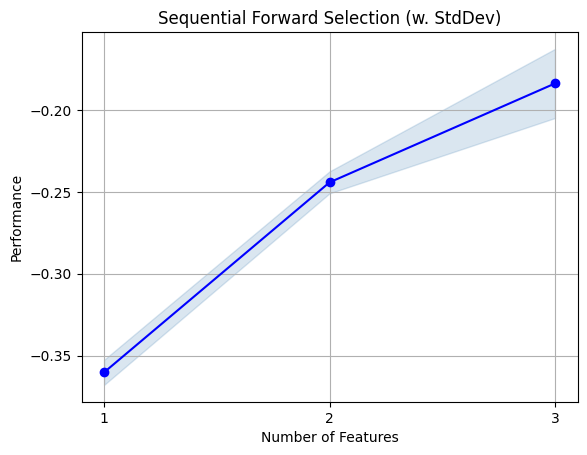

In [51]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [52]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier)
])

rfe_sfs_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('rfe_extractor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [53]:
predictions_sfs = rfe_skl_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_sfs_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
  
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2025/10/18 11:20:08 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/18 11:20:08 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/18 11:20:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_sfs_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/28f4a715430e41fca408cfd483b600c8.
2025/10/18 11:20:09 INFO mlflow

In [54]:
from sklearn.model_selection import  GridSearchCV

param_grid = {
    'model__max_depth': [i for i in range(1,10)],
    'model__n_estimators':[i for i in range(1,5)],
    'model__max_features':[i/10 for i in range(1,10)]
}

gs = GridSearchCV(rfe_sfs_pipeline, param_grid, cv=2, scoring='neg_mean_absolute_error')
gs.fit(X_train, y_train)



c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (522). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (522). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (522). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (522). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than 

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'model__max_depth': [1, 2, ...], 'model__max_features': [0.1, 0.2, ...], 'model__n_estimators': [1, 2, ...]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,None
,refit,True
,cv,2
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...), ...]"


In [55]:
print("Лучшие гиперпараметры:", gs.best_params_)

Лучшие гиперпараметры: {'model__max_depth': 6, 'model__max_features': 0.6, 'model__n_estimators': 4}


In [56]:
classifier_optimized = RandomForestClassifier(max_depth=7, max_features=0.9, n_estimators=4)

In [57]:
rfe_skl_pipeline_optimised = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier_optimized)
])
rfe_skl_pipeline_optimised.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('rfe_extractor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [58]:
predictions_gridSV = rfe_skl_pipeline_optimised.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')
metrics

{'precision': 0.8765043521424293,
 'recall': 0.8710601719197708,
 'f1': 0.8717601193758974}

In [59]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_feature_selection_optimised_GridSearchSV'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
  
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_skl_pipeline_optimised, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2025/10/18 11:20:29 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/18 11:20:29 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/18 11:20:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_feature_selection_optimised_GridSearchSV at: http://127.0.0.1:5000/#/experiments/1/runs/b360f742bcf44ac19e803c97d4560137.
2025/10/18 1

In [60]:

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'optimized_random_forest_v2'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
   
    mlflow.sklearn.log_model(
        rfe_skl_pipeline_optimised, 
        artifact_path="models",
        signature=signature,
        input_example=input_example,
        pip_requirements=req_file
    )
    mlflow.log_metrics(metrics)
    mlflow.log_params(gs.best_params_)  
    
   
    model_version = mlflow.register_model(
        f"runs:/{run_id}/models",
        REGISTRY_MODEL_NAME,
        await_registration_for=300
    )
    
    
    client = mlflow.tracking.MlflowClient()
    client.update_model_version(
        name=REGISTRY_MODEL_NAME,
        version=model_version.version,
        description="Optimized Random Forest with GridSearchCV and RFE feature selection"
    )

print(f"Model registered as version {model_version.version} of {REGISTRY_MODEL_NAME}")

2025/10/18 11:20:29 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/10/18 11:20:30 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
Successfully registered model 'phone_model_rf'.
2025/10/18 11:20:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: phone_model_rf, version

Model registered as version 1 of phone_model_rf


In [61]:

X_full = df.drop('target', axis=1)
y_full = df['target']


production_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier_optimized)
])

production_pipeline.fit(X_full, y_full)


from mlflow.models import infer_signature
signature = infer_signature(model_input=X_full.head(5))
input_example = X_full.head(5)


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'production_model'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    mlflow.sklearn.log_model(
        production_pipeline,
        artifact_path="models",
        signature=signature,
        input_example=input_example,
        pip_requirements=req_file
    )
    
  
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    
  
    model_version = mlflow.register_model(
        f"runs:/{run.info.run_id}/models",
        REGISTRY_MODEL_NAME
    )
    
  
    client = mlflow.tracking.MlflowClient()
    client.set_registered_model_tag(
        name=REGISTRY_MODEL_NAME,
        key="stage",
        value="Production"
    )
    
    
    client.update_model_version(
        name=REGISTRY_MODEL_NAME,
        version=model_version.version,
        description="Production model trained on full dataset with optimized parameters"
    )

print(f"Production model registered as version {model_version.version} of {REGISTRY_MODEL_NAME}")

c:\Users\1\Desktop\IIS\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/10/18 11:26:14 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - seaborn (current: 0.12.2, required: seaborn==0.13.2)
To fix the mismatches, 

Production model registered as version 2 of phone_model_rf
